# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

#importing my fucntions  
from myfunctions import *

#setting a seed value
random.seed(20)
# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
#Counting lines in the files
#https://stackoverflow.com/questions/845058/how-to-get-line-count-cheaply-in-python
total_lines = sum(1 for l in open("Udacity_AZDIAS_Subset.csv"))
#percent of the data to be imported randomly
percent_data = .01
#(1 - percent_data)*total_lines Random indexs to be skiped
skip_ger = sorted(random.sample(range(1,total_lines+1),total_lines-int(total_lines*percent_data)))

azdias and feat_info are DataFrames containing data for general population of Germany and Features/columns details for  general population of Germany

In [3]:
# Load in a percentage of the general demographics data 
azdias =  pd.read_csv("Udacity_AZDIAS_Subset.csv",sep = ';',skiprows = skip_ger)
# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv",sep = ';')
row_numbers(azdias)

total number of Rows:  8912


/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (57,59) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
display(azdias.head(5))
print("General population of Germany for training \n---- \n Number of Rows: ",azdias.shape[0],"\tNumber of columns: ", azdias.shape[1] )

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,3,2,2.0,2,3,4,3,2,3,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,4.0,9.0,4.0
1,-1,2,1,3.0,2,5,1,4,3,4,...,0.0,0.0,3.0,2.0,5.0,3.0,1.0,4.0,9.0,3.0
2,2,4,1,6.0,3,1,5,1,1,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,4.0,7.0,5.0
3,3,9,2,1.0,5,1,5,1,2,3,...,3.0,2.0,1.0,1.0,1.0,3.0,3.0,4.0,9.0,4.0
4,-1,3,1,4.0,3,3,4,2,3,2,...,1.0,4.0,3.0,1.0,3.0,3.0,2.0,3.0,7.0,4.0


General population of Germany for training 
---- 
 Number of Rows:  8912 	Number of columns:  85


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
#converting all the missing values: '', space: ' ', 'X' and 'XX' which are missing for columns CAMEO_DEUG_2015,CAMEO_DEU_2015, 
#CAMEO_INTL_2015 to np.nan 
azdias.replace(['X','XX','',' '],np.nan,inplace=True)

'X' and 'XX' are causing the column to be object type. Converting it to nan will make it
     a float type.<br>
From data Dictionary we can see:<br>
CAMEO_DEUG_2015- missingor unknown [-1,X]<br>
CAMEO_DEU_2015- missing or unknown[XX]<br>
CAMEO_INTL_2015 - missing or unknown[-1,XX]<br>

In [6]:
#parsing missing and unknown from feature summary csv file
miss_unknown_list = [x.replace("[","").replace("]","").split(',')  for x in feat_info['missing_or_unknown']] 

In [7]:
#changing the missing or unknowns type from string to float
miss_unknown_list_f = []
for x in miss_unknown_list:
    #list inside list
    list_in = []
    for mis in x:
        try:
            mis = float(mis)
            list_in.append(mis)
        except:
            mis = np.nan
            list_in.append(mis)
    list_in
    miss_unknown_list_f.append(list_in)

##### note: 
converting all the missing and unkowns to float value because np.nan is a float value 

In [8]:
#missing or unknown in the first variable "AGER_TYP" from feature summary csv file
#changed from str, '[-1,0]'  to listof floats, [-1.0,0.0]
miss_unknown_list_f[0]

[-1.0, 0.0]

In [9]:
# Identify missing or unknown data values and convert them to NaNs.
#Traversing each column and changing the missing or unknown(featrue summary csv) to np.nan
#example for first variable/column "AGER_TYP" -1 and 0 is changed to np.nan
for col,mis_unkwn in zip(azdias.columns,miss_unknown_list_f):
    #continuing the above example for -1 and 0 for the first column "AGER_TYP"
    azdias[col].replace(mis_unkwn,np.nan,inplace = True)    

In [10]:
print("Total NaNs in General population Data:",azdias.isnull().sum().sum())

Total NaNs in General population Data: 84624


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [11]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
#null list Number of NaN in each column
nan_per_col = azdias.isnull().sum().values
#percentage calculated by missing data in each column divided by total number of rows in DataFrame
nan_per_col_percentage = nan_per_col/azdias.shape[0]
#percentage of data missing from each column 
#nan_per_col

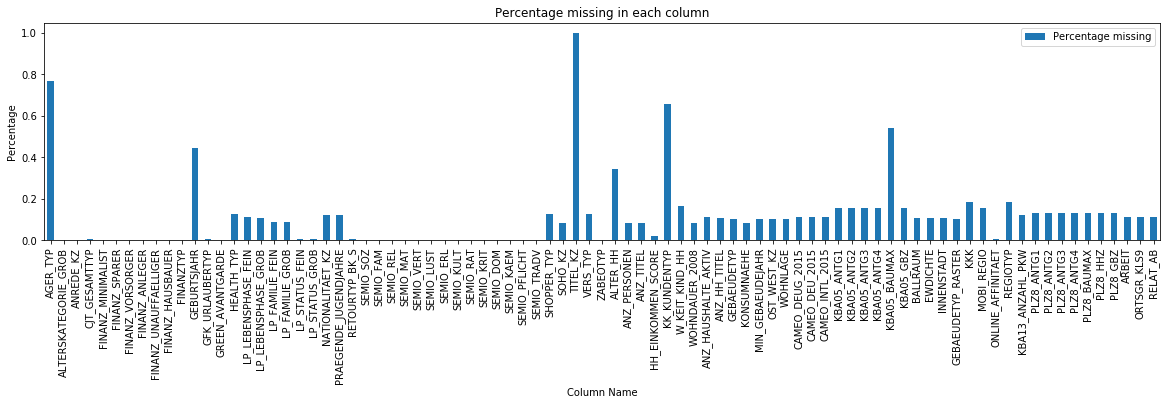

In [12]:
# Investigate patterns in the amount of missing data in each column.
column_nan_ratios(azdias)

In [13]:
#outliers, columns which has more than 35% of data missing
col_outliers = [col for col,per in zip(azdias.columns,nan_per_col_percentage) if per > .35]

**DROPPING OUTLIER COLUMNS having more than 35% missing data**<br>
AGER_TYP - Bet ager topology, GEBURTSJAHR - Date of birth, TITEL_KZ- Acadamic title flag,KK_KUNDENTYP- Categorical data (new customer or active), KBA05_BAUMAX - common building type, Alter_HH - Date of birth - Interval

In [14]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
print("Before Droping Outliers")
print(str(col_numbers(azdias)))
azdias.drop(columns = col_outliers, axis=1,inplace= True, errors = 'ignore')
print("After Droping Outliers")
print(str(col_numbers(azdias)))

Before Droping Outliers
Total number of Columns:  85
None
After Droping Outliers
Total number of Columns:  80
None


#### Discussion 1.1.2: Assess Missing Data in Each Column
- 6 columns shows that there are more than 70% of data missing<br>.
- A lot of Columns have almost same ratios of missing data. this gives a feeling that many rows are having same amount of missing data which is leading to same number of missing data in columns.This trend can be obesered for columns having data missing between 10-20%.
-

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [15]:
# How much data is missing in each row of the dataset?
Rows_missing_data = azdias.isnull().any(axis = 1).sum()
Total_missing_data = azdias.isnull().sum().sum()
print("Rows having atleast one NaN: " +'\t\t' + str(Rows_missing_data))
print("Total number of rows in Dataframe:" + '\t' +str(azdias.shape[0]))
print("Total Number of missing data:" + "\t\t" + str(Total_missing_data))
print("Total number of cells in data:" + '\t\t' + str(azdias.shape[0]*azdias.shape[0]))

Rows having atleast one NaN: 		4424
Total number of rows in Dataframe:	8912
Total Number of missing data:		54217
Total number of cells in data:		79423744


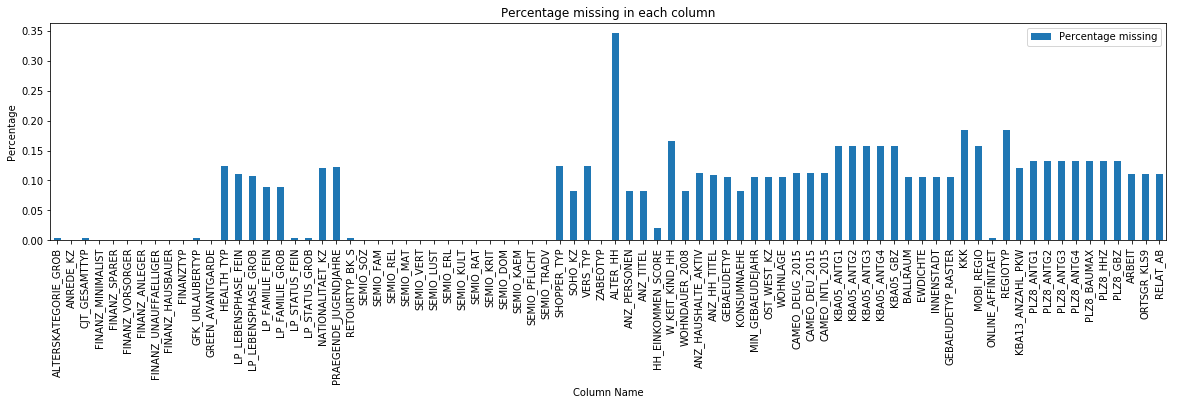

In [16]:
column_nan_ratios(azdias)

#### From the column missing we can see
- KBA05_ANTGXs columns have almost equal number of missing data
- PLZ8_ANTGXs columns also have evqual number of missing data in columns
- Alter_HH, W_KEIT_KIND_HH,KKK,MOBI_REGOTYPE,REGIOTYPE have missing data higher than KBA05_ANTGXs,PLZ8_ANTGXs

####Assuming all these data point come from the same sourse 

In [17]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
threshold = 16
#rows count less than equal to threshold but != 0 NaNs
ls_threshold = azdias.loc[((azdias.isnull().sum(axis = 1)) <= threshold) & ((azdias.isnull().sum(axis = 1)) != 0) ]
#Rows count for NaNs count more than threshold
gr_threshold = azdias.loc[(azdias.isnull().sum(axis = 1)) > threshold]
print("less than equal to threshold rows count:"+ '\t'+ str(ls_threshold.shape[0]))
print("greater than threshold rows count:"+ '\t\t'+ str(gr_threshold.shape[0]))
print("% of data missing more than 12 rows:",gr_threshold.shape[0]/azdias.shape[0]*100)

less than equal to threshold rows count:	3435
greater than threshold rows count:		989
% of data missing more than 12 rows: 11.097396768402154


In [18]:
#average NaNs in each columns
avg_ls_threshold = [ls_threshold[col].isnull().sum()/ls_threshold.shape[0] for col in list(azdias.columns[azdias.isnull().any()])]
avg_gr_threshold = [gr_threshold[col].isnull().sum()/gr_threshold.shape[0] for col in list(azdias.columns[azdias.isnull().any()])]
#avg_gr_threshold

In [19]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
#columns having NaNs
cols = list(azdias.columns[azdias.isnull().any()])
#cols

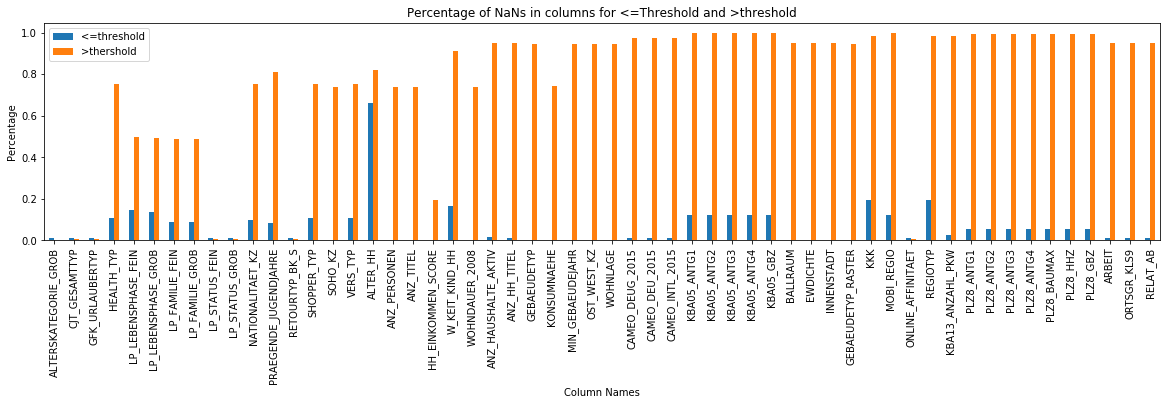

In [20]:
#index = columns having NaNs
#plotting NaNs average in each columns for greater than and less than threshold
df = pd.DataFrame({'<=threshold': avg_ls_threshold,'>thershold': avg_gr_threshold}, index=cols)
ax = df.plot.bar(rot=0,figsize=(20,4))
plt.xticks(rotation=90)
plt.xlabel('Column Names')
plt.ylabel("Percentage")
plt.title('Percentage of NaNs in columns for <=Threshold and >threshold')
plt.show()

In [21]:
#Dropping rows with NaNs more than 2
print("Before dropping, Total Rows:\t" + str(azdias.shape[0])) 
azdias.dropna(thresh = len(azdias.columns)-threshold,inplace = True)
print('Rows Count with NaNs > '+ str(threshold) +':\t' + str(gr_threshold.shape[0]))
print("After dropping, Total Rows  :\t" + str(azdias.shape[0]))    
print(str(col_numbers(azdias)))

Before dropping, Total Rows:	8912
Rows Count with NaNs > 16:	989
After dropping, Total Rows  :	7923
Total number of Columns:  80
None


In [22]:
nan_per_col = azdias.isnull().sum().values
#percentage calculated by missing data in each column divided by total number of rows in DataFrame
nan_per_col_percentage = nan_per_col/azdias.shape[0]
nan_per_col

array([  34,    0,   34,    0,    0,    0,    0,    0,    0,    0,   34,
          0,  370,  497,  465,  308,  308,   34,   34,  336,  295,   34,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,  370,    0,  370,    0, 2269,    0,    0,    0,
        577,    0,   63,   39,    0,    0,    0,    0,    0,   39,   39,
         39,  413,  413,  413,  413,  413,    7,    7,    7,    0,  672,
        413,   34,  672,   95,  196,  196,  196,  196,  196,  196,  196,
         47,   47,   47])

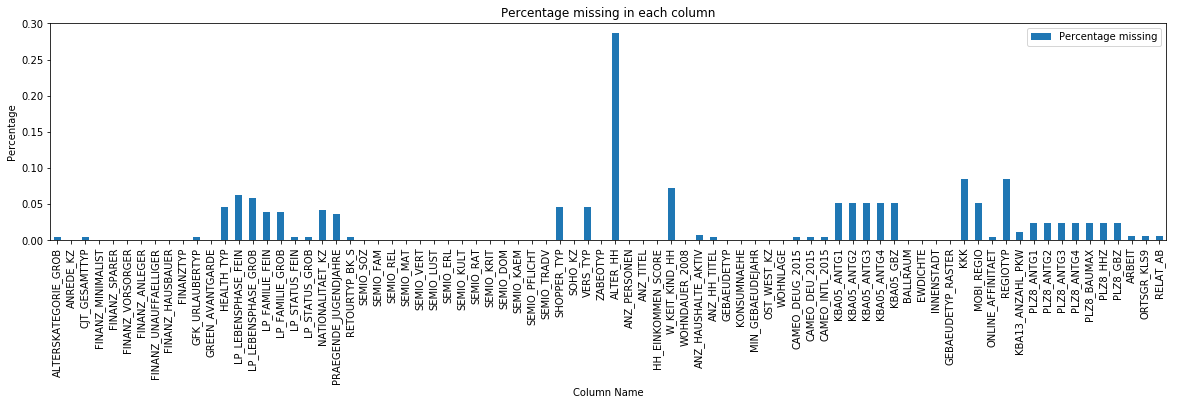

In [23]:
column_nan_ratios(azdias)

In [24]:
azdias.shape[0]

7923

#### Discussion 1.1.3: Assess Missing Data in Each Row

After assuming:<br>
The data points that are having moe than 16NaNs per row, is due to data missing in columns KBA05_ANTGXs(5 columns),PLZ8_ANTGXs(7 columns), W_KEIT_KIND_HH(1),KKK(1),MOBI_REGOTYPE(1),REGIOTYPE(1) and more.
<br>
Setting *16*  as a threshold and deleting these data points having more than 16NaNs. It was seen that *11% of datapoints have more than 16 NaNs* and after deleting them, the number of NaNs in columns KBA05_ANTGXs(5 columns),PLZ8_ANTGXs(7 columns), W_KEIT_KIND_HH(1),KKK(1),MOBI_REGOTYPE(1),REGIOTYPE(1) significantly reduced.<br>

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [25]:
# How many features are there of each data type?
#Displating types with counts
display(feat_info.groupby('type').count()['attribute'])

type
categorical    21
interval        1
mixed           7
numeric         7
ordinal        49
Name: attribute, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [26]:
#Storing column names and type in list[column_name,column_type] inside list cols_and_type
cols_and_type = []
for i,col in enumerate(list(feat_info.attribute)):
    cols_and_type.append([col,feat_info.loc[i,'type']])

### Categorical Features/variables/columns cleaned here

In [27]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

categorical_cols = []
for col, col_type in cols_and_type:
    if col_type == 'categorical':
        categorical_cols.append(col)
#Printing Categorical columns below        
#categorical_cols

**Categorical columns types Binary,Non-numerical or Multilevel**<br>
*Binary* <br> ANREDE_KZ,GREEN_AVANTGARDE, SOHO_KZ,VERS_TYP,OST_WEST_KZ<br>
<br>
*non numerical* <br> CAMEO_DEU_2015,OST_WEST_KZ
<br><br>
*Multi-level*<br>  AGER_TYP,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,<br>LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,TITEL_KZ,ZABEOTYP,KK_KUNDENTYP,GEBAEUDETYP,<br>CAMEO_DEUG_2015


In [28]:
# Re-encode categorical variable(s) to be kept in the analysis.
if 'OST_WEST_KZ' in azdias.columns:
    azdias = pd.get_dummies(azdias, columns=['OST_WEST_KZ'])

**Note:** NaNs are removed in dummies. If not 'W' and 'E' both dummy columns will have 0 for *OST_WEST_KZ_W* and *OST_WEST_KZ_E*

#### Dropping Multilevel Categorical data and Non numeric data after getting dummies for OST_WEST_KZ

In [29]:
drop_col = ['OST_WEST_KZ','CAMEO_DEUG_2015','CAMEO_DEU_2015','AGER_TYP','CJT_GESAMTTYP','FINANZTYP','GFK_URLAUBERTYP','LP_FAMILIE_FEIN','LP_FAMILIE_GROB','LP_STATUS_FEIN','LP_STATUS_GROB','NATIONALITAET_KZ','SHOPPER_TYP','TITEL_KZ','ZABEOTYP','KK_KUNDENTYP','GEBAEUDETYP']
print("Total number of columns to be dropped:\t",len(drop_col))
print("Before Droping columns\n---------")
print(str(col_numbers(azdias)))
azdias.drop(columns = drop_col, axis=1,inplace= True, errors = 'ignore')
print("After Droping columns\n---------")
print(str(col_numbers(azdias)))

Total number of columns to be dropped:	 17
Before Droping columns
---------
Total number of Columns:  81
None
After Droping columns
---------
Total number of Columns:  68
None


In [30]:
nan_per_col = azdias.isnull().sum().values
#percentage calculated by missing data in each column divided by total number of rows in DataFrame
nan_per_col_percentage = nan_per_col/azdias.shape[0]
nan_per_col

array([  34,    0,    0,    0,    0,    0,    0,    0,    0,  370,  497,
        465,  295,   34,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,  370, 2269,    0,    0,
          0,  577,    0,   63,   39,    0,    0,    0,   39,  413,  413,
        413,  413,  413,    7,    7,    7,    0,  672,  413,   34,  672,
         95,  196,  196,  196,  196,  196,  196,  196,   47,   47,   47,
          0,    0])

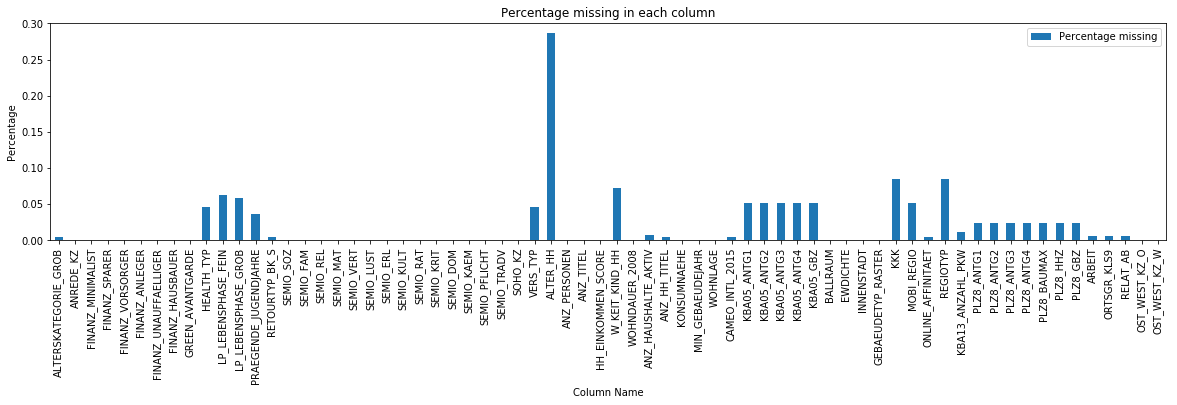

In [31]:
column_nan_ratios(azdias)

#### Discussion 1.2.1: Re-Encode Categorical Features

- ANREDE_KZ,GREEN_AVANTGARDE, SOHO_KZ,VERS_TYP,OST_WEST_KZ are columns with binary values
    - OST_WEST_KZ is re-encoded into dummies
    - ANREDE_KZ - male -1,female -2
    - VERS_TYP - 1,2
    - GREEN_AVANTGARDE,SOHO_KZ are in the binary form 1 and 0
- CAMEO_DEU_2015,OST_WEST_KZ  are columns with non numerical 
- The remaining are multi level are droped form the DataFrames.
- Non Numeric Columns are deleted after re-encoding



#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

### Mixed data cleaned here

In [32]:
#storing columns of 'mixed' type in list
mixed_col = []
for col, col_type in cols_and_type:
    if col_type == 'mixed':
        mixed_col.append(col)

In [33]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

**Defining intervals**<br>-----------------------<br>
- Defining pandas intervals and storing it in 6 variables inv_X0s.<br>
- Storing the pandas intervals in list_inv<br>
- storing list of integers which refers to 40s,50s.. 90s, in list_val as defined in Data_dictionary.md<br>
- Function *return_interval* returns intervals based on the value in the column PRAEGENDE_JUGENDJAHRE

In [34]:
#Column movement storing 1 for Mainstream and 0 for Avantgarde
azdias['MOVEMENT'] = azdias.apply(lambda x: x.PRAEGENDE_JUGENDJAHRE in [1.0,3.0,5.0,8.0,10.0,12.0,14.0], axis=1).astype(float)
#Decade with intercals
azdias['DECADE'] = azdias.apply(lambda row: return_inv_DECADE(row.PRAEGENDE_JUGENDJAHRE), axis=1)

In [35]:
#Checking intervals in column 'decade'
azdias['DECADE'].head(5)

0    4.0
1    6.0
2    2.0
3    1.0
4    5.0
Name: DECADE, dtype: float64

In [36]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
#10s column
azdias['CAMEO_INTL_2015_10s'] = azdias.apply(lambda x: 0 if x.CAMEO_INTL_2015 in [np.nan] else int(int(x.CAMEO_INTL_2015)/10) , axis=1).replace(0,np.nan)
#1s column
azdias['CAMEO_INTL_2015_1s'] = azdias.apply(lambda x: 0 if x.CAMEO_INTL_2015 in [np.nan] else int(x.CAMEO_INTL_2015)%10 , axis=1).replace(0,np.nan)

In [37]:
#Drop mixed columns
print("Before Droping columns\n---------")
print(str(col_numbers(azdias)))
azdias.drop(columns =mixed_col,inplace = True,errors = 'ignore')
print("After Droping columns\n---------")
print(str(col_numbers(azdias)))

Before Droping columns
---------
Total number of Columns:  72
None
After Droping columns
---------
Total number of Columns:  66
None


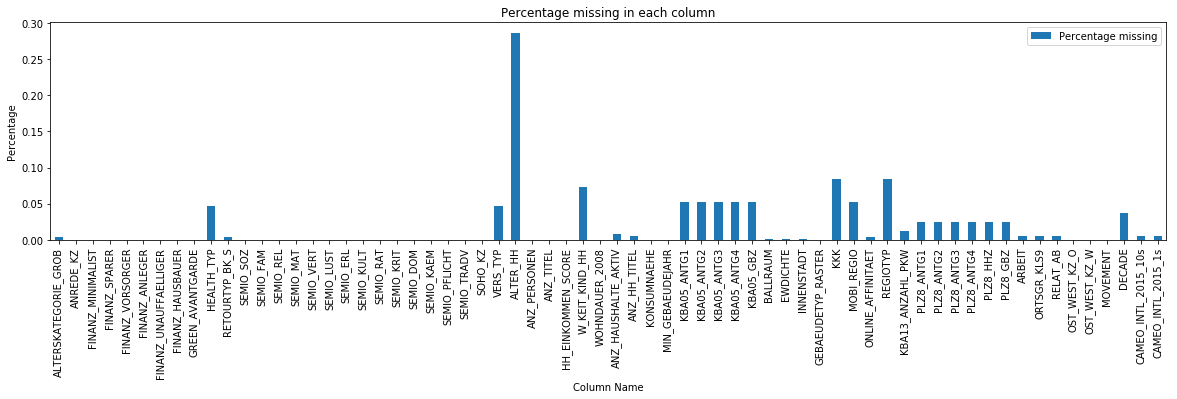

In [38]:
column_nan_ratios(azdias)

#### Discussion 1.2.2: Engineer Mixed-Type Features

- 'PRAEGENDE_JUGENDJAHRE' is used to make 2 variables 'MOVEMENT' and 'DECADE'
-  'CAMEO_INTL_2015' is used to make two new variabels 'CAMEO_INTL_2015_10s', 'CAMEO_INTL_2015_1s' which stores 10s place and 1s place of the values in the column 'CAMEO_INTL_2015'
- The rest of the mixed columns and 'PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015' are droped for the General population Dataframe.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

###  Dealing with Ordinal Columns here

In [39]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

#Finding Columns of type Oridinal
ordinal_col = []
for col, col_type in cols_and_type:
    if col_type == 'ordinal':
        ordinal_col.append(col)
print("Columns of type Ordinal:\t",ordinal_col)
print("\nTotal number of Columns of type Ordinal:\t",len(ordinal_col))

Columns of type Ordinal:	 ['ALTERSKATEGORIE_GROB', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'HEALTH_TYP', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'KONSUMNAEHE', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO', 'ONLINE_AFFINITAET', 'REGIOTYP', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_HHZ', 'PLZ8_GBZ', 'ARBEIT', 'ORTSGR_KLS9', 'RELAT_AB']

Total number of Columns of type Ordinal:	 49


**interval variables**<br>
ALTERSKATEGORIE_GROB - estimated age <br>
WOHNDAUER_2008 - Length of residence<br>
KONSUMNAEHE - Distance from buling to point of sale<br>
BALLRAUM - distance to the nearest urban center<br>
EWDICHTE - DEnsity of households<br>
INNENSTADT - distance to city center<br>
ORTSGR_KLS9 - size of the community<br>
These columns are all interval types, hence are **converted into interval variables**<br><br>The remaining columns shows kinds of affinity "lower","low","medium","high","higher" hence do not carry information which can be converted into numerical or interval data. The remaining rows will be dropped.

In [40]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
list_drop_ordinal = []
for col in ordinal_col:
    if col not in ['ALTERSKATEGORIE_GROB','WOHNDAUER_2008', 'KONSUMNAEHE','BALLRAUM','EWDICHTE','INNENSTADT','ORTSGR_KLS9']:
        list_drop_ordinal.append(col)      
print("Before Droping columns\n---------")
print(str(col_numbers(azdias)))
azdias.drop(columns =list_drop_ordinal,inplace = True,errors = 'ignore')
print("After Droping columns\n---------")
print(str(col_numbers(azdias)))

Before Droping columns
---------
Total number of Columns:  66
None
After Droping columns
---------
Total number of Columns:  24
None


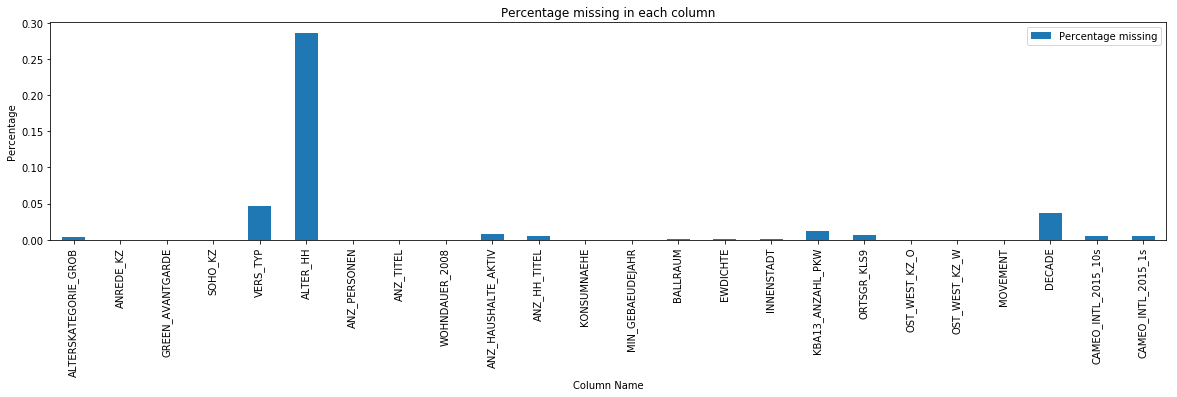

In [41]:
#Analysing missing data in the remaining columns columns
column_nan_ratios(azdias)
#['ALTERSKATEGORIE_GROB','WOHNDAUER_2008', 'KONSUMNAEHE','BALLRAUM','EWDICHTE','INNENSTADT','ORTSGR_KLS9']

In [42]:
azdias.isnull().sum().sum()

3311

#### Discussion 1.2.3
- The ordinal columns are droped as they show affinity for values "low","lower","higher" 
- The columns below show ordinal in terms of numerical values such as age, distance, density hence are not droped
    - ALTERSKATEGORIE_GROB - estimated age 
    - WOHNDAUER_2008 - Length of residence
    - KONSUMNAEHE - Distance from buling to point of sale
    - BALLRAUM - distance to the nearest urban center
    - EWDICHTE - DEnsity of households
    - INNENSTADT - distance to city center
    - ORTSGR_KLS9 - size of the community

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [43]:
# returns cleaned data and count of dropped rows based on NaNs threshold
def clean_data(df,df_features):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    
    # convert missing value codes into NaNs, ...
    #function defined in myfunction.py
    df = replace_to_nans(df,df_features)
    
    # remove selected columns and rows, ...
    #provide input for threshold
    #function defined in myfunction.py
    count,df =  drop_rows_columns(df,16)
    
    # select, re-encode, and engineer column values.
    #function defined in myfunction.py
    df = re_encode(df,df_features,count)
    
    # Return the cleaned dataframe.
    return(df)
    

In [44]:
azdias_fun =  pd.read_csv("Udacity_AZDIAS_Subset.csv",sep = ';',skiprows = skip_ger)

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (57,59) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [45]:
# returns count of dropped rows based on NaNs threshold and cleaned data 
thresh_count_gen,azdias_fun = clean_data(azdias_fun,feat_info)

Log
In Replace to NaNs function
--------------
-Replaced X,XX,space to np.nan
-Completed parsing missing nad unknown
-Completed replacing missing and unknown to NaNs

In drop_rows_columns function
------------
-Dropped Oulier Columns
-Drop Rows with more than 16 NaNs

In re_encode function
------------
Categorical Columns -WIP
   Created Dummies for OST_WEST_KZ
   Dropped Multilevel Categorical columns and Re-encoded OST_WEST_KZ
Mixed data columns -WIP
   Created DECADE AND MOVEMENT for PRAEGENDE_JUGENDJAHRE
   Created CAMEO_INTL_2015_10s AND CAMEO_INTL_2015_1s for CAMEO_INTL_2015
   Dropped mixed column
Ordinal Data columns -WIP
  Dropping Non Interval columns
  Dropping remaining ordinal columns
Success - Return DataFrame


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

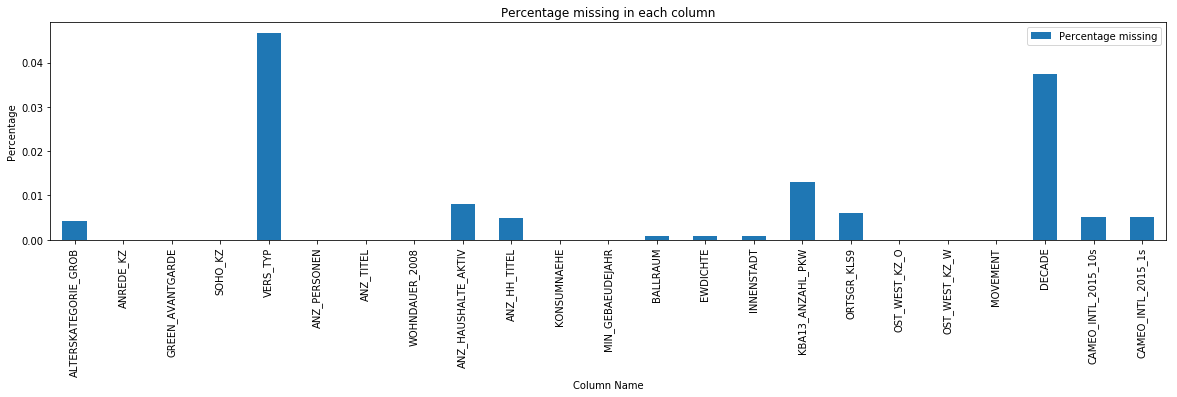

In [46]:
column_nan_ratios(azdias_fun)

In [47]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
#imputing using SimpleImputer and storing it in a new DataFrame azdias_imp
azdias_fun.drop(columns = ['VERS_TYP','DECADE'], axis=1,inplace= True, errors = 'ignore')
from sklearn.impute import SimpleImputer
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
azdias_imp = pd.DataFrame(imp_median.fit_transform(azdias_fun))
azdias_imp.columns = azdias_fun.columns
#azdias_imp.isnull().sum().sum()
azdias_imp.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,ANZ_PERSONEN,ANZ_TITEL,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,...,BALLRAUM,EWDICHTE,INNENSTADT,KBA13_ANZAHL_PKW,ORTSGR_KLS9,OST_WEST_KZ_O,OST_WEST_KZ_W,MOVEMENT,CAMEO_INTL_2015_10s,CAMEO_INTL_2015_1s
0,3.0,2.0,0.0,0.0,1.0,0.0,9.0,13.0,0.0,2.0,...,1.0,5.0,4.0,442.0,9.0,0.0,1.0,1.0,4.0,1.0
1,2.0,1.0,0.0,0.0,1.0,0.0,4.0,25.0,0.0,1.0,...,1.0,6.0,1.0,188.0,9.0,1.0,0.0,1.0,4.0,1.0
2,4.0,1.0,0.0,0.0,1.0,0.0,9.0,19.0,0.0,3.0,...,7.0,6.0,2.0,215.0,7.0,0.0,1.0,1.0,5.0,5.0
3,3.0,2.0,0.0,0.0,0.0,0.0,9.0,4.0,0.0,4.0,...,1.0,5.0,4.0,537.0,9.0,0.0,1.0,1.0,4.0,3.0
4,3.0,1.0,0.0,0.0,1.0,0.0,4.0,9.0,0.0,1.0,...,3.0,6.0,1.0,228.0,7.0,0.0,1.0,1.0,5.0,1.0


Binary-<br>
ANREDE_KZ,GREEN_AVANTGARDE, SOHO_KZ,VERS_TYP, OST_WEST_KZ_O,OST_WEST_KZ_W,MOVEMENT,VERS_TYP

Numerical<br>
ANZ_PERSONEN,'ANZ_TITEL', 'ANZ_HAUSHALTE_AKTIV','ANZ_HH_TITEL',MIN_GEBAEUDEJAHR,KBA13_ANZAHL_PKW,CAMEO_INTL_2015_10s,CAMEO_INTL_2015_1s

Interval<br>
ALTERSKATEGORIE_GROB,KONSUMNAEHE, BALLRAUM,DECADE,ORTSGR_KLS9,INNENSTADT,EWDICHTE


In [48]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
azdias_sca = pd.DataFrame(scaler.fit_transform(azdias_imp))
azdias_sca.columns = azdias_fun.columns
azdias_sca.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,ANZ_PERSONEN,ANZ_TITEL,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,...,BALLRAUM,EWDICHTE,INNENSTADT,KBA13_ANZAHL_PKW,ORTSGR_KLS9,OST_WEST_KZ_O,OST_WEST_KZ_W,MOVEMENT,CAMEO_INTL_2015_10s,CAMEO_INTL_2015_1s
0,0.199556,0.96812,-0.521186,-0.094341,-0.629051,-0.062742,0.566441,0.293886,-0.1267,-0.658106,...,-1.455418,0.604914,-0.281301,-0.515337,1.609413,-0.519426,0.519426,0.578951,0.508610,-1.259832
1,-0.777899,-1.03293,-0.521186,-0.094341,-0.629051,-0.062742,-1.996985,1.051415,-0.1267,-1.299481,...,-1.455418,1.184064,-1.753033,-1.266269,1.609413,1.925203,-1.925203,0.578951,0.508610,-1.259832
2,1.177011,-1.03293,-0.521186,-0.094341,-0.629051,-0.062742,0.566441,0.672651,-0.1267,-0.016732,...,1.297998,1.184064,-1.262456,-1.186446,0.738288,-0.519426,0.519426,0.578951,1.193344,1.432718
3,0.199556,0.96812,-0.521186,-0.094341,-1.470225,-0.062742,0.566441,-0.274260,-0.1267,0.624643,...,-1.455418,0.604914,-0.281301,-0.234476,1.609413,-0.519426,0.519426,0.578951,0.508610,0.086443
4,0.199556,-1.03293,-0.521186,-0.094341,-0.629051,-0.062742,-1.996985,0.041377,-0.1267,-1.299481,...,-0.537613,1.184064,-1.753033,-1.148012,0.738288,-0.519426,0.519426,0.578951,1.193344,-1.259832


### Discussion 2.1: Apply Feature Scaling

- The columns have less than 1% of missing data is imputed with the median of those columns for contuing analysis.
- Columns having missing values more than 1% is deleted. If these are imputed the cluster centers might vary if imputed witht he median.
- The NaNs are replaced by Median of the columns as they are numerical data
- Binary columns
    - ANREDE_KZ,GREEN_AVANTGARDE, SOHO_KZ,VERS_TYP, OST_WEST_KZ_O,OST_WEST_KZ_W,MOVEMENT,VERS_TYP

- Numerical columns
    - ANZ_PERSONEN,'ANZ_TITEL', 'ANZ_HAUSHALTE_AKTIV','ANZ_HH_TITEL',MIN_GEBAEUDEJAHR,KBA13_ANZAHL_PKW,CAMEO_INTL_2015_10s,CAMEO_INTL_2015_1s

- Interval columns
    - ALTERSKATEGORIE_GROB,KONSUMNAEHE, BALLRAUM,DECADE,ORTSGR_KLS9,INNENSTADT,EWDICHTE

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [49]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
pca = PCA()
pca.fit_transform(azdias_sca)
print('pca.fit')

pca.fit


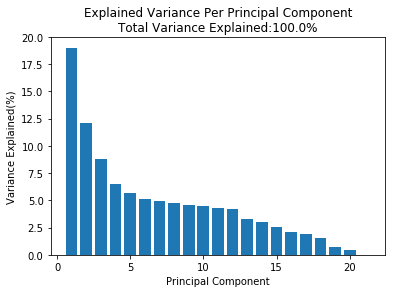

In [50]:
# Investigate the variance accounted for by each principal component.
#print(pca.explained_variance_) 
#print(pca.explained_variance_ratio_)
show_var_for_comp(azdias_sca,21)

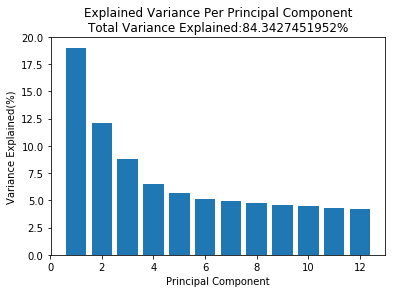

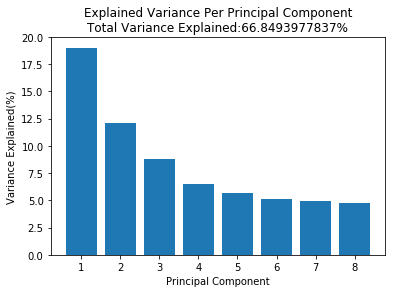

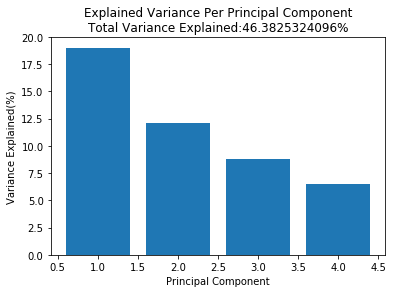

In [51]:
show_var_for_comp(azdias_sca,12)
show_var_for_comp(azdias_sca,8)
show_var_for_comp(azdias_sca,4)

In [52]:
# Re-apply PCA to the data while selecting for number of components to retain.
ncom = 3
pca = PCA(n_components=ncom)
pca.fit_transform(azdias_sca)
pca.explained_variance_ratio_.sum()

0.39929019163700852

In [53]:
component = pd.DataFrame(np.round(pca.components_[0].reshape(1,len(azdias_sca.keys())), 4), columns = azdias_sca.keys())
component

,ALTERSKATEGORIE_GROB,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,ANZ_PERSONEN,ANZ_TITEL,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,...,BALLRAUM,EWDICHTE,INNENSTADT,KBA13_ANZAHL_PKW,ORTSGR_KLS9,OST_WEST_KZ_O,OST_WEST_KZ_W,MOVEMENT,CAMEO_INTL_2015_10s,CAMEO_INTL_2015_1s
0,-0.0572,-0.0058,-0.0639,-0.0064,-0.1155,0.0064,-0.0547,0.2325,0.0827,-0.321,...,-0.3382,0.4251,-0.3854,-0.1493,0.43,0.0619,-0.0619,0.0535,0.3063,-0.1998


### Discussion 2.2: Perform Dimensionality Reduction

- As the number of compnents are reduced from 21 to 4 the total explained varience is changing significantly.
- For components eaqual to the number of featues,total explainedd variance is 100%
- For the final computaion number of components selected is 3.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

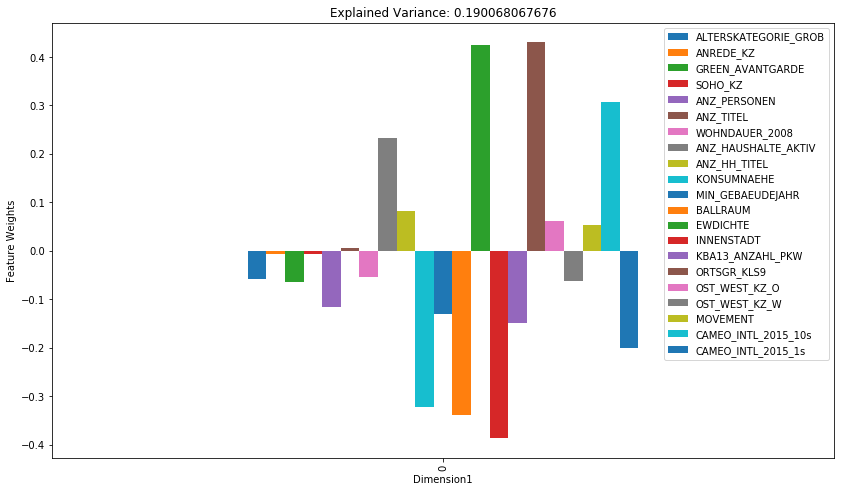

In [54]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
show_ith_comp_wt(azdias_sca,pca,1)


- EWDICHTE,ORTSGR_KLS9,CAMEO_INTL_2015_10s have positive weights more than .3, by the first component. This shows that this component maximizes the variance of these features.
- INNENSTADT, BALLARAUM,KONSUMNAEHE have large negative weights

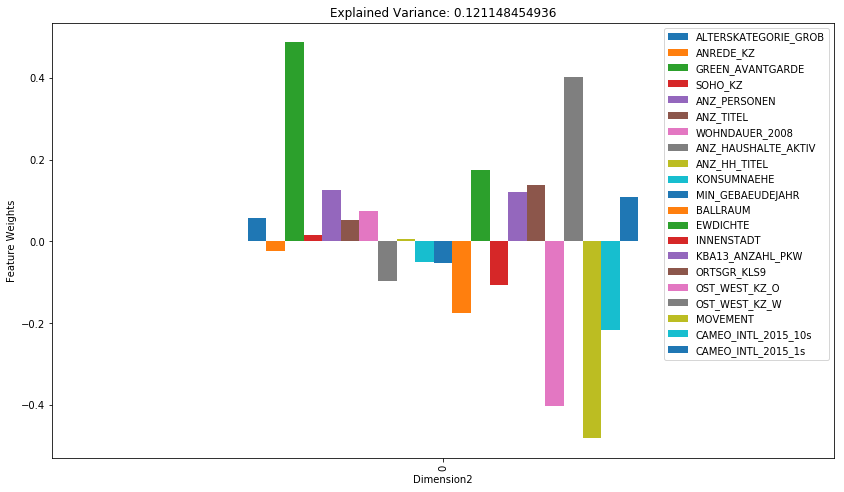

In [55]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
show_ith_comp_wt(azdias_sca,pca,2)


GREEN_AVANTGARADE, OST_WEST_KZ_W have large positive weights. The 2nd compnent is in the direction of these features.
MOVEMENT, OST_WEST_KZ_O have large negative weights.

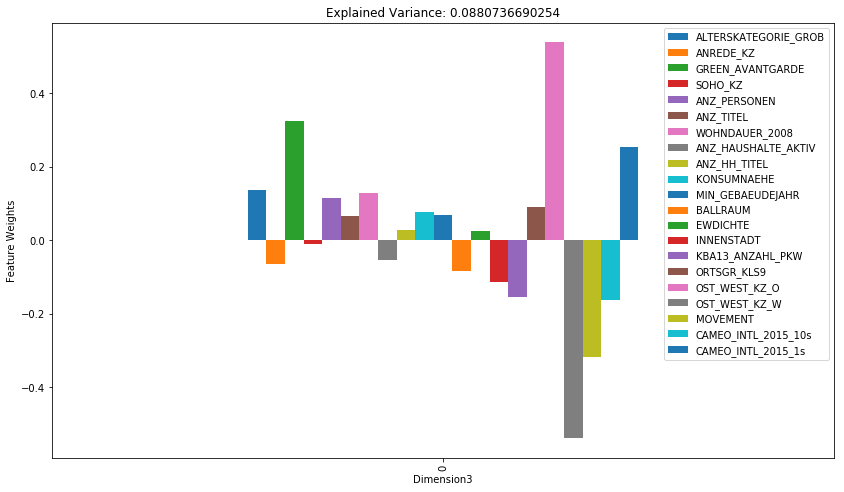

In [56]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
show_ith_comp_wt(azdias_sca,pca,3)


OST_WEST_KZ_W,OST_WEST_KZ_O have oppositive sign of weights than the third component.

### Discussion 2.3: Interpret Principal Components

**1st component**<br>
     -Positive 
        - EWDICHTE - Density of households per square kilometer
        - ORTSGR_KLS9 - Size of community
        - CAMEO_INTL_2015_10s - Wealth / Life Stage Typology, mapped to international code
     - Neagtive
        - INNENSTADT - Distance to city center 
        - BALLARAUM - Distance to nearest urban center
        - KONSUMNAEHE - Distance from building to point of sale 
**2nd Component**<br>
    - Positive
        - GREEN_AVANTGARADE - Membership in environmental sustainability as part of youth
        - OST_WEST_KZ_W - Building location via former West Germany
    - Negative 
        - MOVEMENT - Dominating movement of person's youth (avantgarde vs. mainstream;
        - OST_WEST_KZ_O -  Building location via former East 
**3rd Component**<br>
    - OST_WEST_KZ_W 
    - OST_WEST_KZ_O

**First Component**<br>
1. The first component beautifully shows variance along the distances to the city center, urban centers, point of sale with negative weights.<br>
2. The density, size of the community shows high variance along the 1st component.

**Second component**
1. Show direction in feature describing West of Germany and negative direction to the East of germany.

**Third component**
1. Shows opposite weights for west and East of Germany as compared to the 2nd component

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [57]:
dimensions = ['Dimension {}'.format(i) for i in range(1,ncom+1)]

In [58]:
azdias_pca = pca.fit_transform(azdias_sca)

In [59]:
azdias_pca = pd.DataFrame(azdias_pca, columns =dimensions)
azdias_pca.head()

,Dimension 1,Dimension 2,Dimension 3
0,2.378594,0.160965,-1.055545
1,4.197019,-1.883059,1.437516
2,1.307298,-0.141411,-0.265072
3,1.620503,0.228745,-0.717920
4,3.110910,-0.175006,-1.290675


In [60]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
# Over a number of different cluster counts...
scores_list = np.array([])
for i in range(2,14):
    clusterer = KMeans(n_clusters = i, random_state = 20).fit(azdias_pca)
    preds = clusterer.predict(azdias_pca)
    scores_list = np.append(scores_list,round(silhouette_score(azdias_pca, preds),3))   

In [61]:
clusters = ['{} Clusters'.format(i) for i in range(2,14)]

In [62]:
scores_list_df = pd.DataFrame(scores_list.reshape(1,12),columns = clusters, index = ['Scores'])
scores_list_df

,2 Clusters,3 Clusters,4 Clusters,5 Clusters,6 Clusters,7 Clusters,8 Clusters,9 Clusters,10 Clusters,11 Clusters,12 Clusters,13 Clusters
Scores,0.331,0.392,0.436,0.473,0.423,0.428,0.44,0.43,0.39,0.382,0.377,0.361


Text(0.5,1,'Scores vs number of clusters')

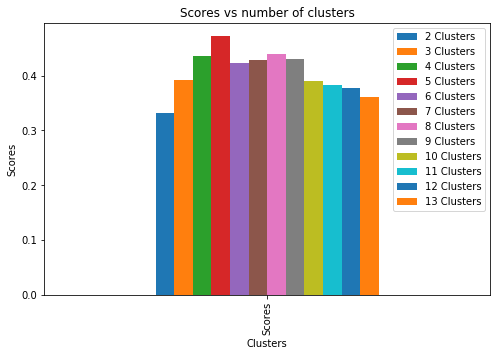

In [63]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
scores_list_df.plot(kind = 'bar',figsize = (8,5))
plt.ylabel('Scores')
plt.xlabel('Clusters')
plt.title('Scores vs number of clusters')

In [64]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
clusterer = KMeans(n_clusters = 5, random_state = 0).fit(azdias_pca)
preds = clusterer.predict(azdias_pca)
score = round(silhouette_score(azdias_pca, preds),3) 
pca_center = clusterer.cluster_centers_
score

0.47299999999999998

In [65]:
centers = pca.inverse_transform(pca_center)

In [66]:
true_centers = pd.DataFrame(scaler.inverse_transform(centers))
true_centers.columns = azdias_fun.columns
true_centers.index = ['Center {}'.format(i) for i in range(1,6)]

In [67]:
true_centers

,ALTERSKATEGORIE_GROB,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,ANZ_PERSONEN,ANZ_TITEL,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,...,BALLRAUM,EWDICHTE,INNENSTADT,KBA13_ANZAHL_PKW,ORTSGR_KLS9,OST_WEST_KZ_O,OST_WEST_KZ_W,MOVEMENT,CAMEO_INTL_2015_10s,CAMEO_INTL_2015_1s
Center 1,2.979888,1.491237,0.013830,0.003782,1.800583,0.003119,8.154712,5.732108,0.019765,4.088354,...,5.711153,2.360116,5.696810,488.301677,3.640522,0.972828,0.027172,0.963704,3.001191,3.555249
Center 2,2.569188,1.538070,0.081751,0.009234,1.401331,0.001604,7.485028,15.670014,0.088363,1.957666,...,2.885877,5.348847,3.278571,580.597828,7.020408,0.017981,0.982019,0.878654,4.247858,1.999178
Center 3,2.730315,1.556385,0.052915,0.010563,1.782313,-0.002033,7.757910,3.904287,-0.011883,3.717912,...,5.645814,2.650794,6.116789,733.796914,3.434513,0.013910,0.986090,0.923109,2.898430,2.912352
Center 4,3.130916,1.455379,0.864908,0.011476,2.359126,0.017054,8.599326,0.966324,0.038419,3.332035,...,3.577950,4.208643,4.366637,699.478215,5.580099,0.012394,0.987606,0.071839,1.898529,3.875191
Center 5,2.797211,1.468673,0.063235,0.002323,1.367615,0.007663,7.848699,19.360513,0.137143,2.027018,...,2.456773,5.535105,2.362378,311.797050,7.855510,0.967482,0.032518,0.895347,4.552791,2.503222


### Discussion 3.1: Apply Clustering to General Population
- Used silhouette_score to score kmean clusters. 
- Kmeans done for number of clusters between 2-14
- Maximum Score of .473 for 5 number of clusters for General Population converted into 3 Principals compnent.
- 5 Clusters namely Cluster_0,Cluster_1,Cluster_2,Cluster_3,Cluster_4

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [68]:
total_lines = sum(1 for l in open("Udacity_CUSTOMERS_Subset.csv"))
#percent of the data to be imported randomly
percent_data = .05
#(1 - percent_data)*total_lines Random indexs to skip to get percent_data
skip_ger = sorted(random.sample(range(1,total_lines+1),total_lines-int(total_lines*percent_data)))


In [69]:
# Load in the customer demographics data.
customers =  pd.read_csv("Udacity_CUSTOMERS_Subset.csv",sep = ';',skiprows = skip_ger)

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (57,59) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [70]:
thresh_count_cust,customers_cleaned= clean_data(customers,feat_info)
customers_cleaned.drop(columns = ['VERS_TYP','DECADE'], axis=1,inplace= True, errors = 'ignore')

Log
In Replace to NaNs function
--------------
-Replaced X,XX,space to np.nan
-Completed parsing missing nad unknown
-Completed replacing missing and unknown to NaNs

In drop_rows_columns function
------------
-Dropped Oulier Columns
-Drop Rows with more than 16 NaNs

In re_encode function
------------
Categorical Columns -WIP
   Created Dummies for OST_WEST_KZ
   Dropped Multilevel Categorical columns and Re-encoded OST_WEST_KZ
Mixed data columns -WIP
   Created DECADE AND MOVEMENT for PRAEGENDE_JUGENDJAHRE
   Created CAMEO_INTL_2015_10s AND CAMEO_INTL_2015_1s for CAMEO_INTL_2015
   Dropped mixed column
Ordinal Data columns -WIP
  Dropping Non Interval columns
  Dropping remaining ordinal columns
Success - Return DataFrame


In [71]:
print("\nColumns of General population and Customer equal or not:\n--------------\n",customers_cleaned.columns ==azdias_imp.columns)


Columns of General population and Customer equal or not:
--------------
 [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True]


In [72]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
#imputing missing values
customers_cleaned_imp = pd.DataFrame(imp_median.fit_transform(customers_cleaned))

#ScalerTransformation
customers_sca = pd.DataFrame(scaler.fit_transform(customers_cleaned_imp))

#PCA Transformation #ncom = 3
pca = PCA(n_components=ncom)
customers_pca = pca.fit_transform(customers_sca)
customers_pca = pd.DataFrame(customers_pca, columns =dimensions)

#Predicting Clusters
preds_cust = clusterer.predict(customers_pca)



In [73]:
#forming Dataframe to store Customer predictions
preds_cust_df = pd.DataFrame(preds_cust)
#counting data points in each cluster
cus_s = preds_cust_df[0].value_counts()

In [74]:
#forming Dataframe to store General population
preds_gen_df = pd.DataFrame(preds)
#counting data points in each cluster
gen_s = preds_gen_df[0].value_counts()

In [75]:
#forming Dataframe to store both Customer ans General Population cluster counts.
df_gen_cus = pd.concat([cus_s, gen_s], axis=1)
df_gen_cus.columns = ['Customer','General']
df_gen_cus = df_gen_cus.transpose()
df_gen_cus[5] = [thresh_count_cust,thresh_count_gen]

In [76]:
#Dataframe for Customer and General Population cluster Counts
df_gen_cus.columns = ['Cluster_{}'.format(i) for i in range(0,6)]
df_gen_cus

,Cluster_0,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5
Customer,252,1597,2733,1616,869,2515
General,905,2269,2502,1524,735,977


In [77]:
#converting CLuster counts into Ratios
df_gen_cus.loc['Customer'] = df_gen_cus.loc['Customer']/df_gen_cus.loc['Customer'].sum()
df_gen_cus.loc['General'] = df_gen_cus.loc['General']/df_gen_cus.loc['General'].sum()

#### Discussion Step 3.2
- Formed a cleaned dataframe for customers
- A new dataframe containing cluster counts for Customer and General Population
- Formed a new column for a new cluster for the dropped rows in Customer DataFrame nad General Population DataFrame

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

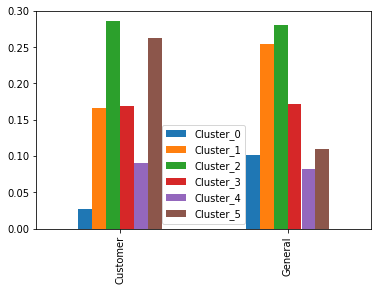

In [78]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
df_gen_cus.plot(kind='bar')

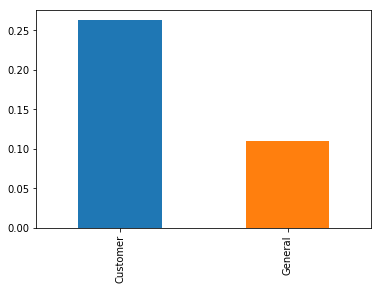

In [79]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

df_gen_cus['Cluster_5'].plot(kind='bar')

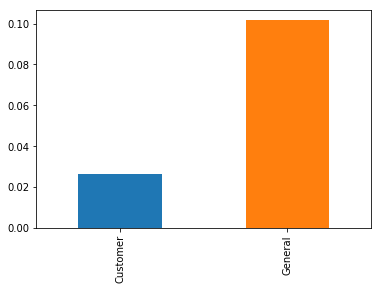

In [82]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
df_gen_cus['Cluster_0'].plot(kind='bar')


In [85]:
centers = pca.inverse_transform(pca_center)
true_centers = pd.DataFrame(scaler.inverse_transform(centers))
true_centers.columns = azdias_fun.columns
true_centers.index = ['Center {}'.format(i) for i in range(0,5)]
true_centers

,ALTERSKATEGORIE_GROB,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,ANZ_PERSONEN,ANZ_TITEL,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,...,BALLRAUM,EWDICHTE,INNENSTADT,KBA13_ANZAHL_PKW,ORTSGR_KLS9,OST_WEST_KZ_O,OST_WEST_KZ_W,MOVEMENT,CAMEO_INTL_2015_10s,CAMEO_INTL_2015_1s
Center 0,3.664220,1.132022,0.951880,0.007430,2.751935,0.038765,9.124588,-2.268718,-0.016015,3.478889,...,4.556281,3.625416,5.346499,841.194236,4.513591,-0.432334,1.432334,0.044052,1.633531,3.697563
Center 1,3.405323,1.404221,0.551248,0.009721,2.012716,0.029993,8.491599,9.621411,0.152656,2.535193,...,2.972168,5.103361,3.323765,540.240824,6.895242,0.324146,0.675854,0.439864,3.068232,3.313803
Center 2,3.558221,1.251983,0.619199,0.013275,2.774225,0.026190,8.939750,-3.760759,-0.141320,4.061974,...,5.462588,2.744797,5.921462,733.428661,3.716479,0.171165,0.828835,0.377038,1.709058,3.794331
Center 3,3.368038,1.482629,-0.267400,0.005664,1.769918,-0.016848,8.178550,13.840007,0.236389,3.015050,...,5.572649,2.967459,5.812517,701.627686,3.754245,0.034588,0.965412,1.252907,3.654014,2.569655
Center 4,3.481421,1.314967,0.852423,0.003207,1.846193,0.042245,8.586250,13.635650,0.332229,1.686920,...,1.667328,6.367383,2.324969,614.457891,8.208197,-0.250422,1.250422,0.137339,3.254243,3.115672


### Discussion 3.3: Compare Customer Data to Demographics Data

- Cluster_5 with NaNs more than 16 is over represented in Customer Data,
- Cluster_0 is underreperested and shoud be the target  audience
FEmale(ANREDE_KZ),No small Office,home office (SOHO_KZ),Number of adults in household 3, Number of professional degree = 0, Lengthof residense more than 10 years, building is located 500m - 1km square from point of sale(KONSUMNAEHE), population density 90- 300 per square km, lives in west of germany, movement -= Avantgarde, wealthy or prosperous households, 


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.